Notebook to interpolate from A grid to C grid

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import numpy as np

import os
import glob

%matplotlib inline

In [2]:
basedir='/data/hdd/salishsea/'
date='20170401'
Agrid_fileU = glob.glob(os.path.join(basedir,'model_Agrid', date,'*{}*U*.nc'.format(date)))[0]
Agrid_fileV = glob.glob(os.path.join(basedir,'model_Agrid', date,'*{}*V*.nc'.format(date)))[0]

orig_fileU = glob.glob(os.path.join(basedir,'model_orig', date,'*{}*U*.nc'.format(date)))[0]
orig_fileV = glob.glob(os.path.join(basedir,'model_orig', date,'*{}*V*.nc'.format(date)))[0]


In [3]:
AfU = nc.Dataset(Agrid_fileU)
AfV = nc.Dataset(Agrid_fileV)
ofU = nc.Dataset(orig_fileU)
ofV = nc.Dataset(orig_fileV)

mesh=nc.Dataset(os.path.join(basedir,'grid','mesh_mask201702.nc'))

In [4]:
nav_lon_U = mesh.variables['glamu'][0,:]
nav_lon_V = mesh.variables['glamv'][0,:]
nav_lon_T = mesh.variables['glamt'][0,:]

nav_lat_U = mesh.variables['gphiu'][0,:]
nav_lat_V = mesh.variables['gphiv'][0,:]
nav_lat_T = mesh.variables['gphit'][0,:]

gdepT = mesh.variables['gdept_0']
print(gdepT.shape)

#umask = mesh.variables['umask'][:]
#vmask = mesh.variables['vmask'][:]
#tmask = mesh.variables['tmask'][:]

(1, 40, 898, 398)


In [5]:
U_agrid = AfU.variables['vozocrtx'][:]
V_agrid = AfV.variables['vomecrty'][:]
t = AfU.variables['time_counter'][:]


In [6]:
%%time
points = (nav_lon_T.flatten(), nav_lat_T.flatten())
shape=nav_lon_T.shape
U_cgrid = np.zeros_like(U_agrid)
V_cgrid = np.zeros_like(V_agrid)
for t in range(U_cgrid.shape[0]):
    print(t)
    for k in range(U_cgrid.shape[1]):
        U_cgrid[t,k,:,:] = interp.griddata(points,U_agrid[t,k,:,:].flatten(),(nav_lon_U,nav_lat_U))
        V_cgrid[t,k,:,:] = interp.griddata(points,V_agrid[t,k,:,:].flatten(),(nav_lon_V,nav_lat_V))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
CPU times: user 2h 46min 12s, sys: 3min 1s, total: 2h 49min 14s
Wall time: 2h 49min 13s


In [7]:
umask = mesh.variables['umask'][:]
U_cgrid_mask = np.ma.masked_array(U_cgrid,mask=np.logical_not(umask + np.zeros_like(U_cgrid)))
vmask = mesh.variables['vmask'][:]
V_cgrid_mask = np.ma.masked_array(V_cgrid,mask=np.logical_not(vmask + np.zeros_like(V_cgrid)))


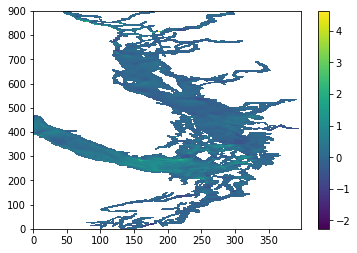

In [8]:
plt.pcolormesh(U_cgrid_mask[0,0,:,:])
plt.colorbar()

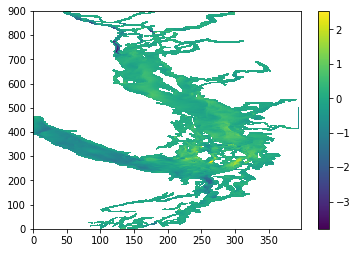

In [9]:
plt.pcolormesh(V_cgrid_mask[0,0,:,:])
plt.colorbar()

In [10]:
uorig = ofU.variables['vozocrtx'][:]
uorig = np.ma.masked_array(uorig, mask=np.logical_not(umask+np.zeros_like(uorig)))
diffU = uorig - U_cgrid_mask

In [11]:
print(diffU.max(), diffU.min(), diffU.mean())

1.01561 -1.11272 -7.81647296103e-05


In [14]:
vorig = ofV.variables['vomecrty'][:]
vorig = np.ma.masked_array(vorig, mask=np.logical_not(vmask+np.zeros_like(vorig)))
diffV = vorig - V_cgrid_mask

In [15]:
print(diffV.max(), diffV.min(), diffV.mean())

1.20864 -1.47134 -2.86875474985e-05


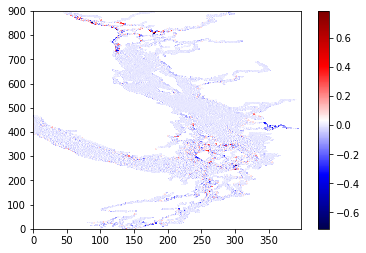

In [18]:
plt.pcolormesh(diffU[0,0,:,:],cmap='seismic')
plt.colorbar()

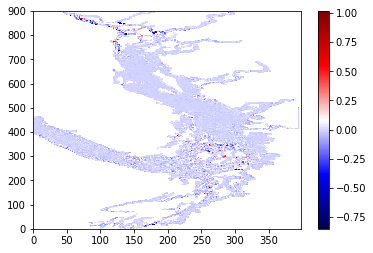

In [19]:
plt.pcolormesh(diffV[0,0,:,:], cmap='seismic')
plt.colorbar()